In [1]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import csv

sc = StandardScaler()

def gen_rows(stream, max_length=None):
    rows = csv.reader(stream)
    if max_length is None:
        rows = list(rows)
        max_length = max(len(row) for row in rows)
    for row in rows:
        yield row + [None] * (max_length - len(row))

with open('./sample_data.csv') as f:
    x_train = pd.DataFrame.from_records(list(gen_rows(f)))

y_train = pd.read_csv('./sample_label.csv')
# x_train = pd.read_csv('./sample_data.csv', names=list(range(8192)))

x_train = x_train.iloc[:].values
x_train = np.array(x_train, dtype=np.float)
x_train[np.isnan(x_train)] = 0
# x_train = sc.fit_transform(x_train)
y_train = y_train.iloc[:].values
y_train = map(lambda x: x[1], y_train)
y_train = np.fromiter(y_train, dtype = np.int)



ValueError: num must be 1 <= num <= 4, not 5

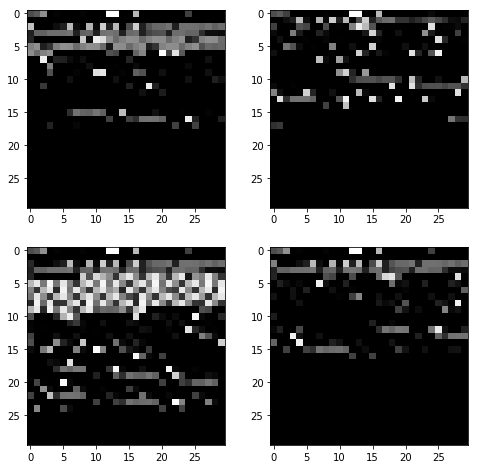

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig=plt.figure(figsize=(8, 8))
n = 1

for i in range(100):
    if(y_train[i] == 0):
        im = x_train[i, 0: 900].astype(int)
        im = im.reshape(30, 30)
        a = fig.add_subplot(2, 2, n)
        n += 1
#         a.set_title(y_train[i])
        plt.gray()
        plt.imshow(im)

ValueError: num must be 1 <= num <= 1, not 2

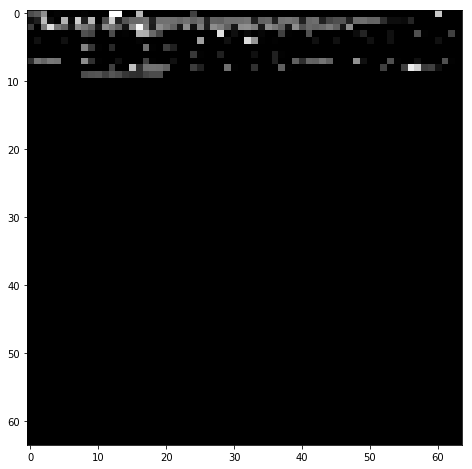

In [39]:
fig=plt.figure(figsize=(8, 8))
n = 1

for i in range(100):
    if(y_train[i] == 1):
        im = x_train[i].astype(int)
        im = im.reshape(64, 64)
        a = fig.add_subplot(1, 1, n)
        n += 1
        plt.gray()
        plt.imshow(im)

In [7]:
x_reshaped_train = np.zeros((x_train.shape[0], 30, 30, 1))

for i in range(x_train.shape[0]):
    x_reshaped_train[i] = x_train[i, 0: 900].astype(int).reshape(30, 30, 1)

In [8]:
print(x_reshaped_train.shape)

(500, 30, 30, 1)


In [9]:
y_reshaped_train = np.zeros((y_train.shape[0], 2), dtype=int)
for i in range(y_train.shape[0]):
    if(y_train[i] == 0):
        y_reshaped_train[i] = [1, 0]
    else:
        y_reshaped_train[i] = [0, 1]


In [10]:
cnt = 0
for i in range(x_train.shape[0]):
    if(y_train[i] == 1):
        cnt += 1
        
print(cnt / 500)

0.638


In [25]:
num_classes = 2
import keras
from keras import Sequential
from keras.layers import *

batch_size = 32
epochs = 100


model = Sequential()
model.add(Conv2D(32, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu',
                 input_shape=(30, 30, 1)))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.01),
              metrics=['accuracy'])

model.fit(x_reshaped_train, y_reshaped_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)
#           validation_data=(x_test, y_test),
#           callbacks=[history])



Epoch 1/100
500/500 [==============================] - 8s 17ms/step - loss: 5.6900 - acc: 0.6200
Epoch 2/100
500/500 [==============================] - 7s 14ms/step - loss: 5.8348 - acc: 0.6380
Epoch 3/100
500/500 [==============================] - 7s 14ms/step - loss: 5.8348 - acc: 0.6380
Epoch 4/100
500/500 [==============================] - 7s 14ms/step - loss: 5.8348 - acc: 0.6380
Epoch 5/100
500/500 [==============================] - 7s 14ms/step - loss: 5.8348 - acc: 0.6380
Epoch 6/100
500/500 [==============================] - 7s 14ms/step - loss: 5.8348 - acc: 0.6380
Epoch 7/100
500/500 [==============================] - 7s 14ms/step - loss: 5.8348 - acc: 0.6380
Epoch 8/100
500/500 [==============================] - 7s 14ms/step - loss: 5.8348 - acc: 0.6380
Epoch 9/100
500/500 [==============================] - 7s 14ms/step - loss: 5.8348 - acc: 0.6380
Epoch 10/100
500/500 [==============================] - 7s 14ms/step - loss: 5.8348 - acc: 0.6380
Epoch 11/100
500/500 [=======

In [2]:
d_train = lgb.Dataset(x_train, label=y_train)

# print(d_train)

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 50
params['max_depth'] = 100


clf = lgb.train(params, d_train, 10)

y_pred=clf.predict(x_train)
#convert into binary values
for i in range(x_train.shape[0]):
    if y_pred[i]>=.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0

y_pred = y_pred.astype(np.int)

# print(y_pred)
# print(y_train)

# # result = 0
# # for i in range(y_pred.shape[0]):
# # 	if(y_pred[i] != y_train[i]):
# # 		result += 1

# # print("ACCURACY ")
# # print((y_pred.shape[0] - result) / y_pred.shape[0])

cm = confusion_matrix(y_train, y_pred)

print(cm)
accuracy=accuracy_score(y_pred,y_train)

print(accuracy)

[[137  44]
 [ 27 292]]
0.858
